# Qiskit Runtime

## Background

There are several methods by which one can access IBM Quantum systems.  Each of these routines can be thought of as a [device driver](https://en.wikipedia.org/wiki/Device_driver), providing a software interface to quantum hardware.

### `backend.run()`

 - The original method of access to IBM Quantum systems
 
 - Access via `qiskit-ibm-provider` package
 
 - Can be viewed as an open-source, vendor agnostic device driver
 
 - Provides direct access to sampling data from device with no pre- or post-processing
 
 - Ideal for users wanting to characterize / benchmark quantum systems, or looking to develop software such as error mitigation techniques
 
 - Requires users to possess comprehensive knowledge of hardware details to be successful

### Qiskit Runtime

As quantum computing matures, and users further detached from device physics gain interest, it is important to abstract as much of the knowledge required for using `backend.run()` away from users, so that focus can be on building applications and algorithms.

The **Qiskit Runtime** is a quantum device driver designed to abstract many details away from users, and give a high-fidelity managed user experience to those who prefer a more automated execution process.  Specifically, IBM Quantum knows many of the knobs that, to first-order, give best results and can be automatically set for users.  For these features, the options and code can be pushed into a cloud execution environment.

The Qiskit Runtime provides:

   - A simple interface that abstracts away hardware details, and removes the need for boilerplate code
   
   - Accessed through the `qiskit-ibm-runtime` package
   
   - By default, does a variety of pre- and post-processing steps (including error suppression and mitigation) that aim to improve returned results
   
   - Can be viewed as a closed-source, vendor specific device driver
   
   - Ideal for users at the level of algorithms and applications
   
   - Not as flexible as `backend.run()`

The Runtime consists of a collection of "primitives"; common quantum computational routines that are executed in a dockerized cloud environment.  The two primitives available to date are:

| Primitive | What it does | Inputs | Outputs |
| --- | --- | --- | --- |
| **Sampler** | Samples circuit output distributions, possibly with error mitigation | Quantum circuits | Quasi-probability distributions \[distributions with (possibly) negative values, but that sums to one\] |
| **Estimator** | Computes expectation values for operators and states defined by circuits, possibly with error mitigation | Quantum circuits and operators | A list of expectation values (and error estimates) |


<div class="alert alert-info">
   <div>
       <big><b>Info</b></big>
   </div>
   <br>
    Technically <mono>backend.run()</mono> is implemented as a Runtime program like the primitives listed above.
</div>

In what follows, we will learn how to use the tools available via the Qiskit Runtime to execute quantum circuits on actual quantum hardware.

## Setup

In [1]:
# Basic imports
import time
import numpy as np

# Optimization from SciPy
from scipy.optimize import curve_fit

# Basic Qiskit imports
from qiskit import QuantumCircuit
from qiskit.visualization import plot_distribution

# Operators from Qiskit and fidelity
from qiskit.quantum_info import SparsePauliOp, hellinger_fidelity

# Primitives from Qiskit
from qiskit.primitives import Sampler as QiskitSampler
from qiskit.primitives import Estimator as QiskitEstimator

# IBM Quantum Runtime account and primitives
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Options, Session


# Plotting tools
import matplotlib.pyplot as plt
try:
    plt.style.use('quantum-light')
except:
    pass
%config InlineBackend.figure_format = 'retina'

## Runtime service instance

### Saving account information locally (optional)

If you have never used IBM Quantum hardware for your local computer, before you begin, you need to save your account information locally.  The token that needs to be saved is available on the [IBM Quantum Platform homepage](https://quantum-computing.ibm.com/).  To save the token you must run:

### Loading account

Provided that you have saved your account info locally, you can instantiate the service:

In [2]:
#service = QiskitRuntimeService()
service = QiskitRuntimeService(instance='ibm-q-skku/2023-quantum-lea/2023-quantum-lea',)

From the service we can do a variety of things.  For example, query the devices and simulators that we have access to:

In [9]:
service.backends()

[<IBMBackend('ibm_auckland')>,
 <IBMBackend('ibm_cairo')>,
 <IBMBackend('ibm_hanoi')>,
 <IBMBackend('ibmq_kolkata')>,
 <IBMBackend('ibmq_mumbai')>,
 <IBMBackend('ibm_algiers')>,
 <IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('simulator_stabilizer')>,
 <IBMBackend('simulator_statevector')>,
 <IBMBackend('ibm_lagos')>,
 <IBMBackend('ibm_seattle')>,
 <IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('ibmq_qasm_simulator_de')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('ibmq_quito')>,
 <IBMBackend('ibmq_guadalupe')>,
 <IBMBackend('ibmq_jakarta')>,
 <IBMBackend('ibmq_manila')>,
 <IBMBackend('ibm_bangkok')>,
 <IBMBackend('ibm_kyiv')>,
 <IBMBackend('ibm_prague')>,
 <IBMBackend('ibm_perth')>,
 <IBMBackend('ibm_cleveland')>,
 <IBMBackend('ibm_nazca')>,
 <IBMBackend('ibm_nairobi')>,
 <IBMBackend('ibm_wellington')>,
 <IBMBackend('alt_auckland')>,
 <IBMBackend('ibm_sherbrooke')>,
 <IBMBackend('ibmq_lima')>,
 <IBMBackend('ibm_quebec')>,
 <IBMBackend('ibmq_belem')>,
 <IBMBackend('ib

Return a list of the previous identification numbers (`job_id`) for jobs we have submitted to any backend:

In [10]:
service.jobs()

[<RuntimeJob('ciruo1erg0h7hq0kr8m0', 'estimator')>,
 <RuntimeJob('cirund5s8tuuanqrketg', 'estimator')>,
 <RuntimeJob('cirukacb0ilk0bcqakqg', 'estimator')>,
 <RuntimeJob('cirugs3c2439q3688cm0', 'estimator')>,
 <RuntimeJob('cirt4cdlipn2bccttceg', 'circuit-runner')>,
 <RuntimeJob('cirsb0tlipn2bcct9hg0', 'circuit-runner')>,
 <RuntimeJob('cirrjn6uepl8219820pg', 'sampler')>,
 <RuntimeJob('cirrjmsb0ilk0bcn7h70', 'sampler')>,
 <RuntimeJob('cirrjmuuepl821982080', 'sampler')>,
 <RuntimeJob('cirrjmkt4v68ftdt7q9g', 'sampler')>]

or filter for a specific backend, etc.

In [11]:
service.jobs(backend_name='ibm_algiers')

[<RuntimeJob('cild076uepl060qcdbn0', 'sampler')>,
 <RuntimeJob('cikolikb0ilvhai9s9b0', 'sampler')>,
 <RuntimeJob('cifi0mju5mrpmccdotmg', 'sampler')>,
 <RuntimeJob('cifhm7j5n9v6ta7kqqrg', 'sampler')>,
 <RuntimeJob('chjr0q46f7i49rotibq0', 'circuit-runner')>,
 <RuntimeJob('chjr0pc6f7i49rotiac0', 'circuit-runner')>,
 <RuntimeJob('chjr0olnopt07g23a1v0', 'circuit-runner')>,
 <RuntimeJob('chjr0nj7ca17j34c9mv0', 'circuit-runner')>,
 <RuntimeJob('chjr0mpike34bjgkc2h0', 'circuit-runner')>,
 <RuntimeJob('chjr0mepqnphtdto4d5g', 'circuit-runner')>]

By far, the most important thing you can do from the service instance is to select a backend on which to run your circuits:

In [3]:
backend = service.get_backend('ibm_canberra')

## Sampling problems

Sampling problems are fundamental to quantum computation.  Indeed, at the end of the day, the only thing a quantum computer can do is sample from probability distributions.  Algorithms such as Grover's, Bernstein-Vazarani, Shor's, Quantum Phase Estimation (QPE), etc. all are bit-string sampling routines.  The `Sampler` routine is the runtime primitive that performs such samplings, returning a distribution to the user.

To begin, let us define a simple circuit generator that generates Bernstein-Vazarani circuits where the solution is the all-ones bit-string of a given length.  For example, a length 4 bit-string, requiring 5-qubits in total, is

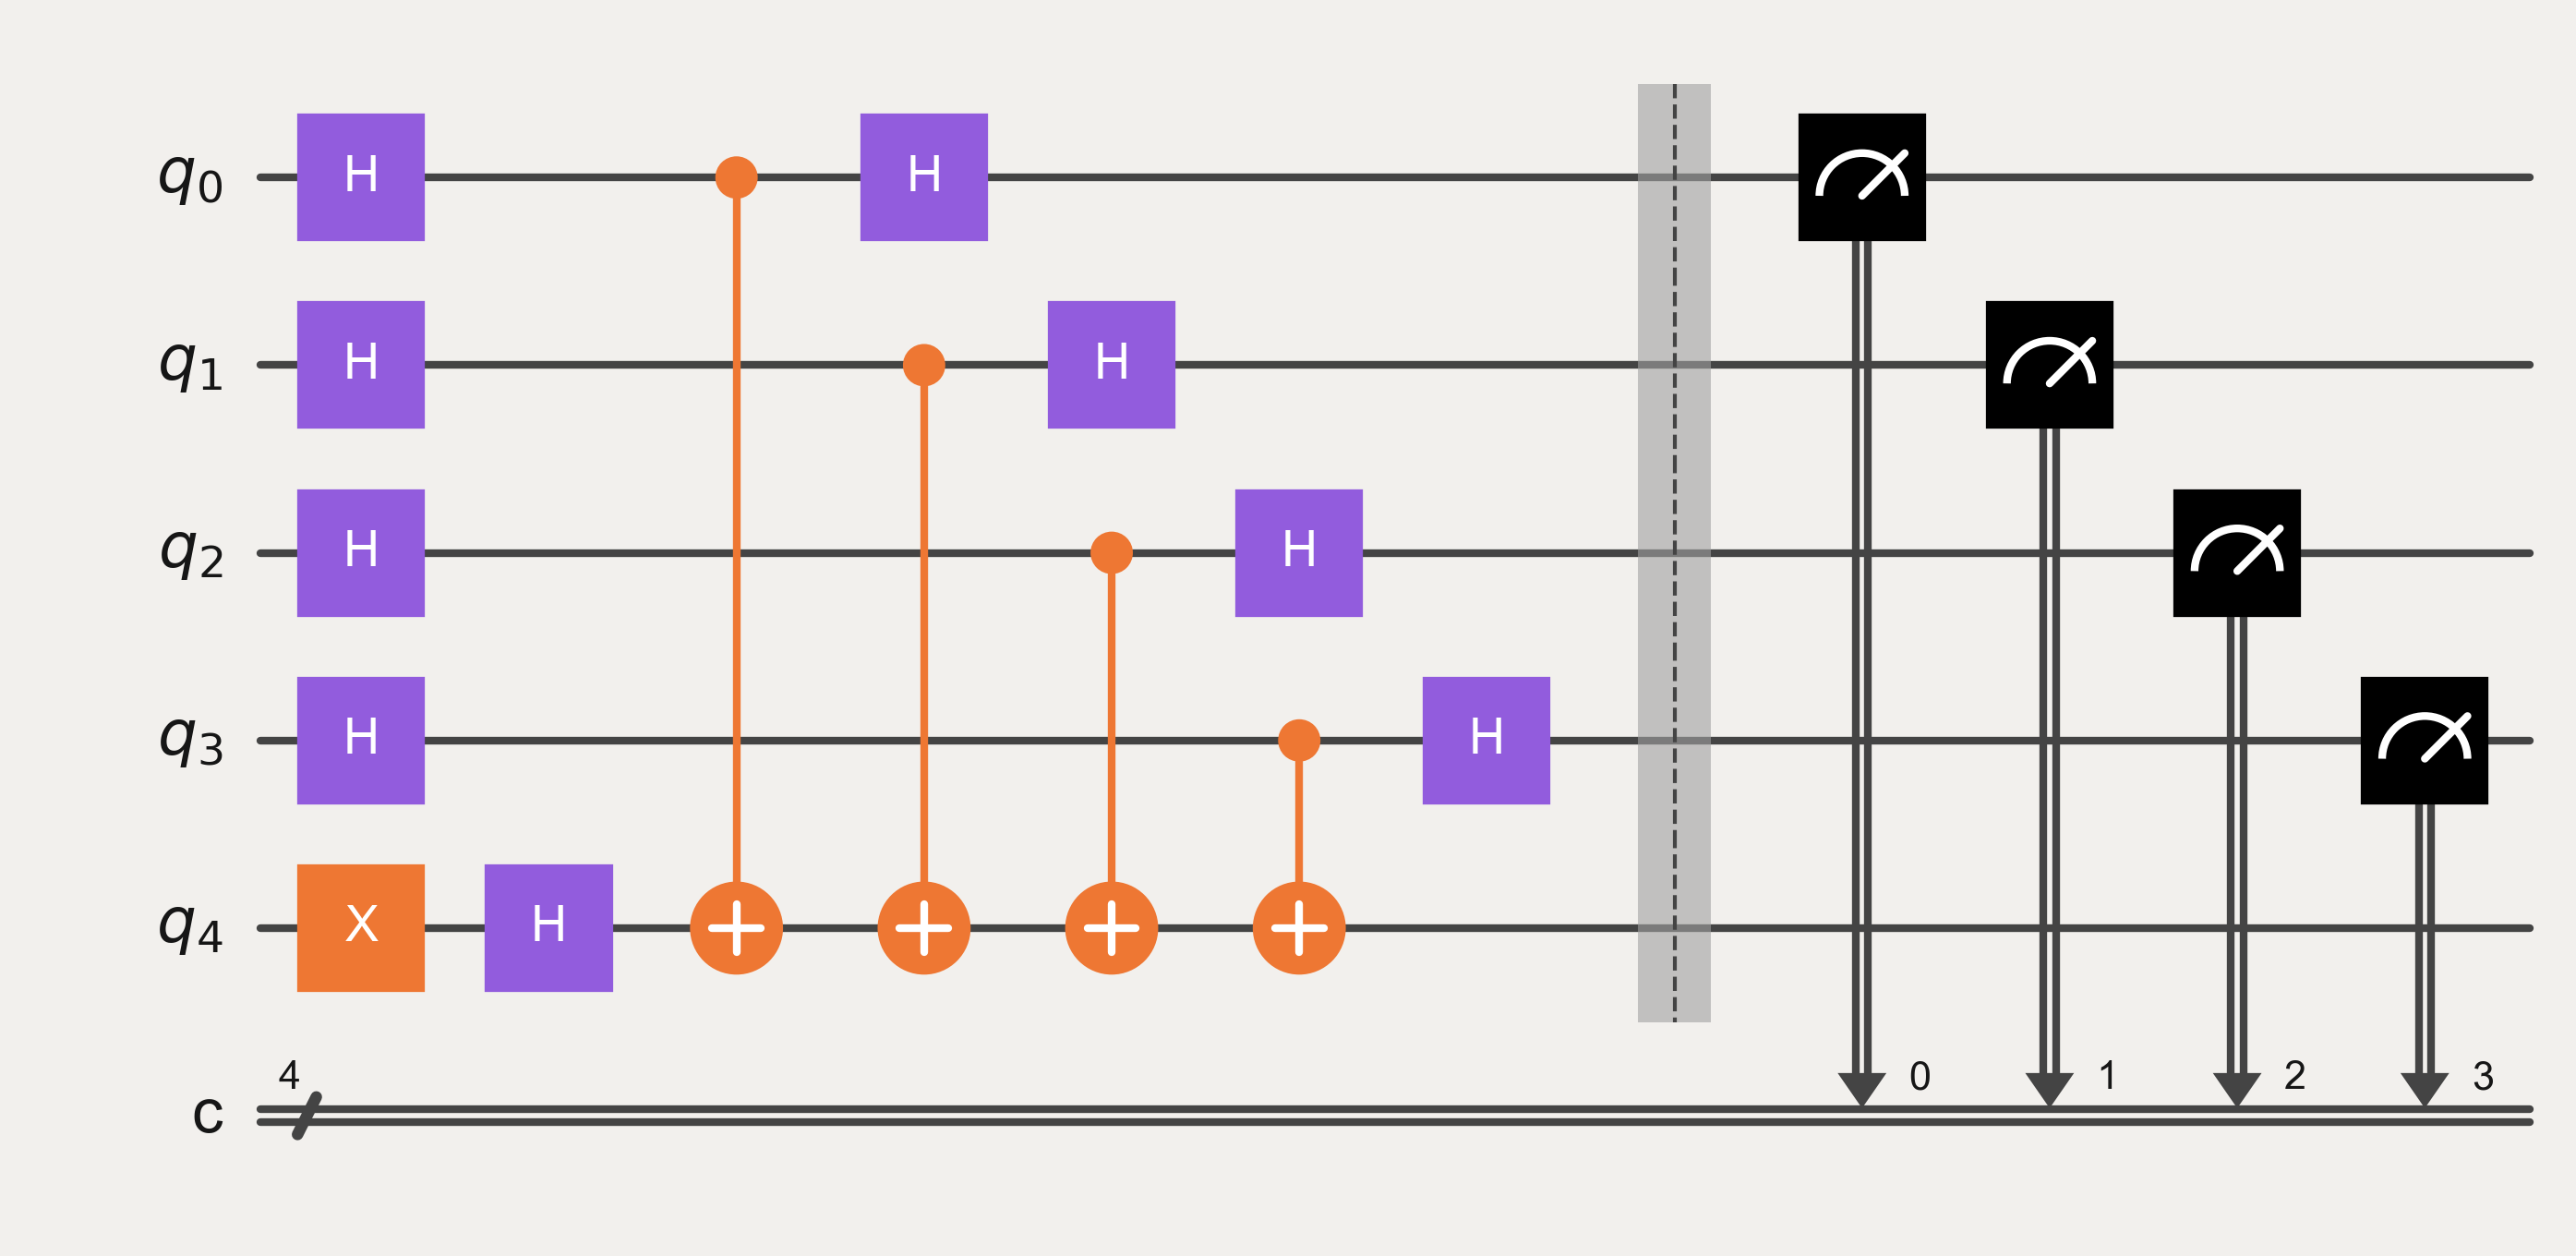

In [4]:
def bv_ones_circs(N):
    """Generate a Bernstein-Vazarani (BV) circuit for an all-ones bit-string
    
    Parameters:
        N (int): Number of qubits in circuit.  I.e. a bit-string of length N-1
        
    Returns:
        QuantumCircuit: BV circuit
    """
    qc = QuantumCircuit(N, N-1)
    qc.x(N-1)
    qc.h(range(N))
    qc.cx(range(N-1), N-1)
    qc.h(range(N-1))
    qc.barrier()
    qc.measure(range(N-1), range(N-1))
    return qc

N = 5
qc = bv_ones_circs(N)
qc.draw('mpl')

As a general rule, for small circuits, it is always good to verify that the circuit does what it is supposed to do.  This can be done with the Qiskit built-in `Sampler`, here called `QiskitSampler`, as it computes the numerically-exact answers via statevector simulation.

In [17]:
qiskit_sampler = QiskitSampler()

In [18]:
ideal_res = qiskit_sampler.run(qc).result()
ideal_res

SamplerResult(quasi_dists=[{15: 0.9999999999999986}], metadata=[{}])

We see that the result object has two items.  First is `quasi_dists`, short-hand for quasi-probability distributions.  Although a quantum computer samples probability distributions, to accommodate error mitigation techniques, the type of distribution that is returned needs to be more general to include distributions that have negative values, but still sum to one.  These distributions are known as quasi-probability distributions.  The second item, `metadata`, which is empty here, is a dictionary that is used to hold additional data, as we will see.

The `quasi_dist` attribute is a list with one element for each circuit given:

In [19]:
ideal_res.quasi_dists

[{15: 0.9999999999999986}]

Quasi-distribution states are given as integers rather than bit-strings, and the values are not discrete counts, but probabilities.  This is because, as the number of qubits grows, the size of the bit-string keys grows larger than the equivalent integer representation.  We can covert this data to bit-strings if desired:

In [20]:
ideal_res.quasi_dists[0].binary_probabilities()

{'1111': 0.9999999999999986}

In this form we can see that indeed, the output is the all-ones bit-string corresponding to the target integer $2^{N-1}-1$.  We now turn to executing the circuit on a real device:

First, we need to instantiate an instance of the `Sampler` from the Qiskit Runtime, passing our target backend to let it know which device to sample from:

In [21]:
sampler = Sampler(backend)

Beyond that, everything works pretty much the same:

In [22]:
job = sampler.run(qc)
# Print the job_id just in case
job.job_id()

'cirvhsh1s2cfkgtu1gr0'

In [23]:
res = job.result()

In [24]:
res.quasi_dists

[{0: 0.020489671448520312,
  1: 0.008814333776570928,
  3: 0.0010793014773669664,
  4: 0.0007150982374513601,
  6: 0.000621916578315506,
  7: 0.0032595183963740272,
  9: 0.00014875383105467308,
  10: 0.0002116700652100062,
  11: 0.008391884541923442,
  12: 0.005553045517693862,
  13: 0.015086632863749555,
  14: 0.018122160081887752,
  15: 0.9175060131838814}]

We see that our answer is no longer a single integer, but a distribution of integers with weights, some of which might be negative. That there are multiple integers in the distribution is due to noise that is present in all current-day quantum hardware.  That the probabilities can go negative, is a consequence of error mitigation (for measurement errors) being applied behind the scene.  However, we should still recover the correct answer to high-probability:

In [25]:
res.quasi_dists[0][2**(N-1)-1]

0.9175060131838814

or in bit-string notation:

In [26]:
res.quasi_dists[0].binary_probabilities()['1'*(N-1)]

0.9175060131838814

We can also plot the results.  It is best to do so with the `plot_distribution` function since our data is not discrete, i.e. not a histogram.

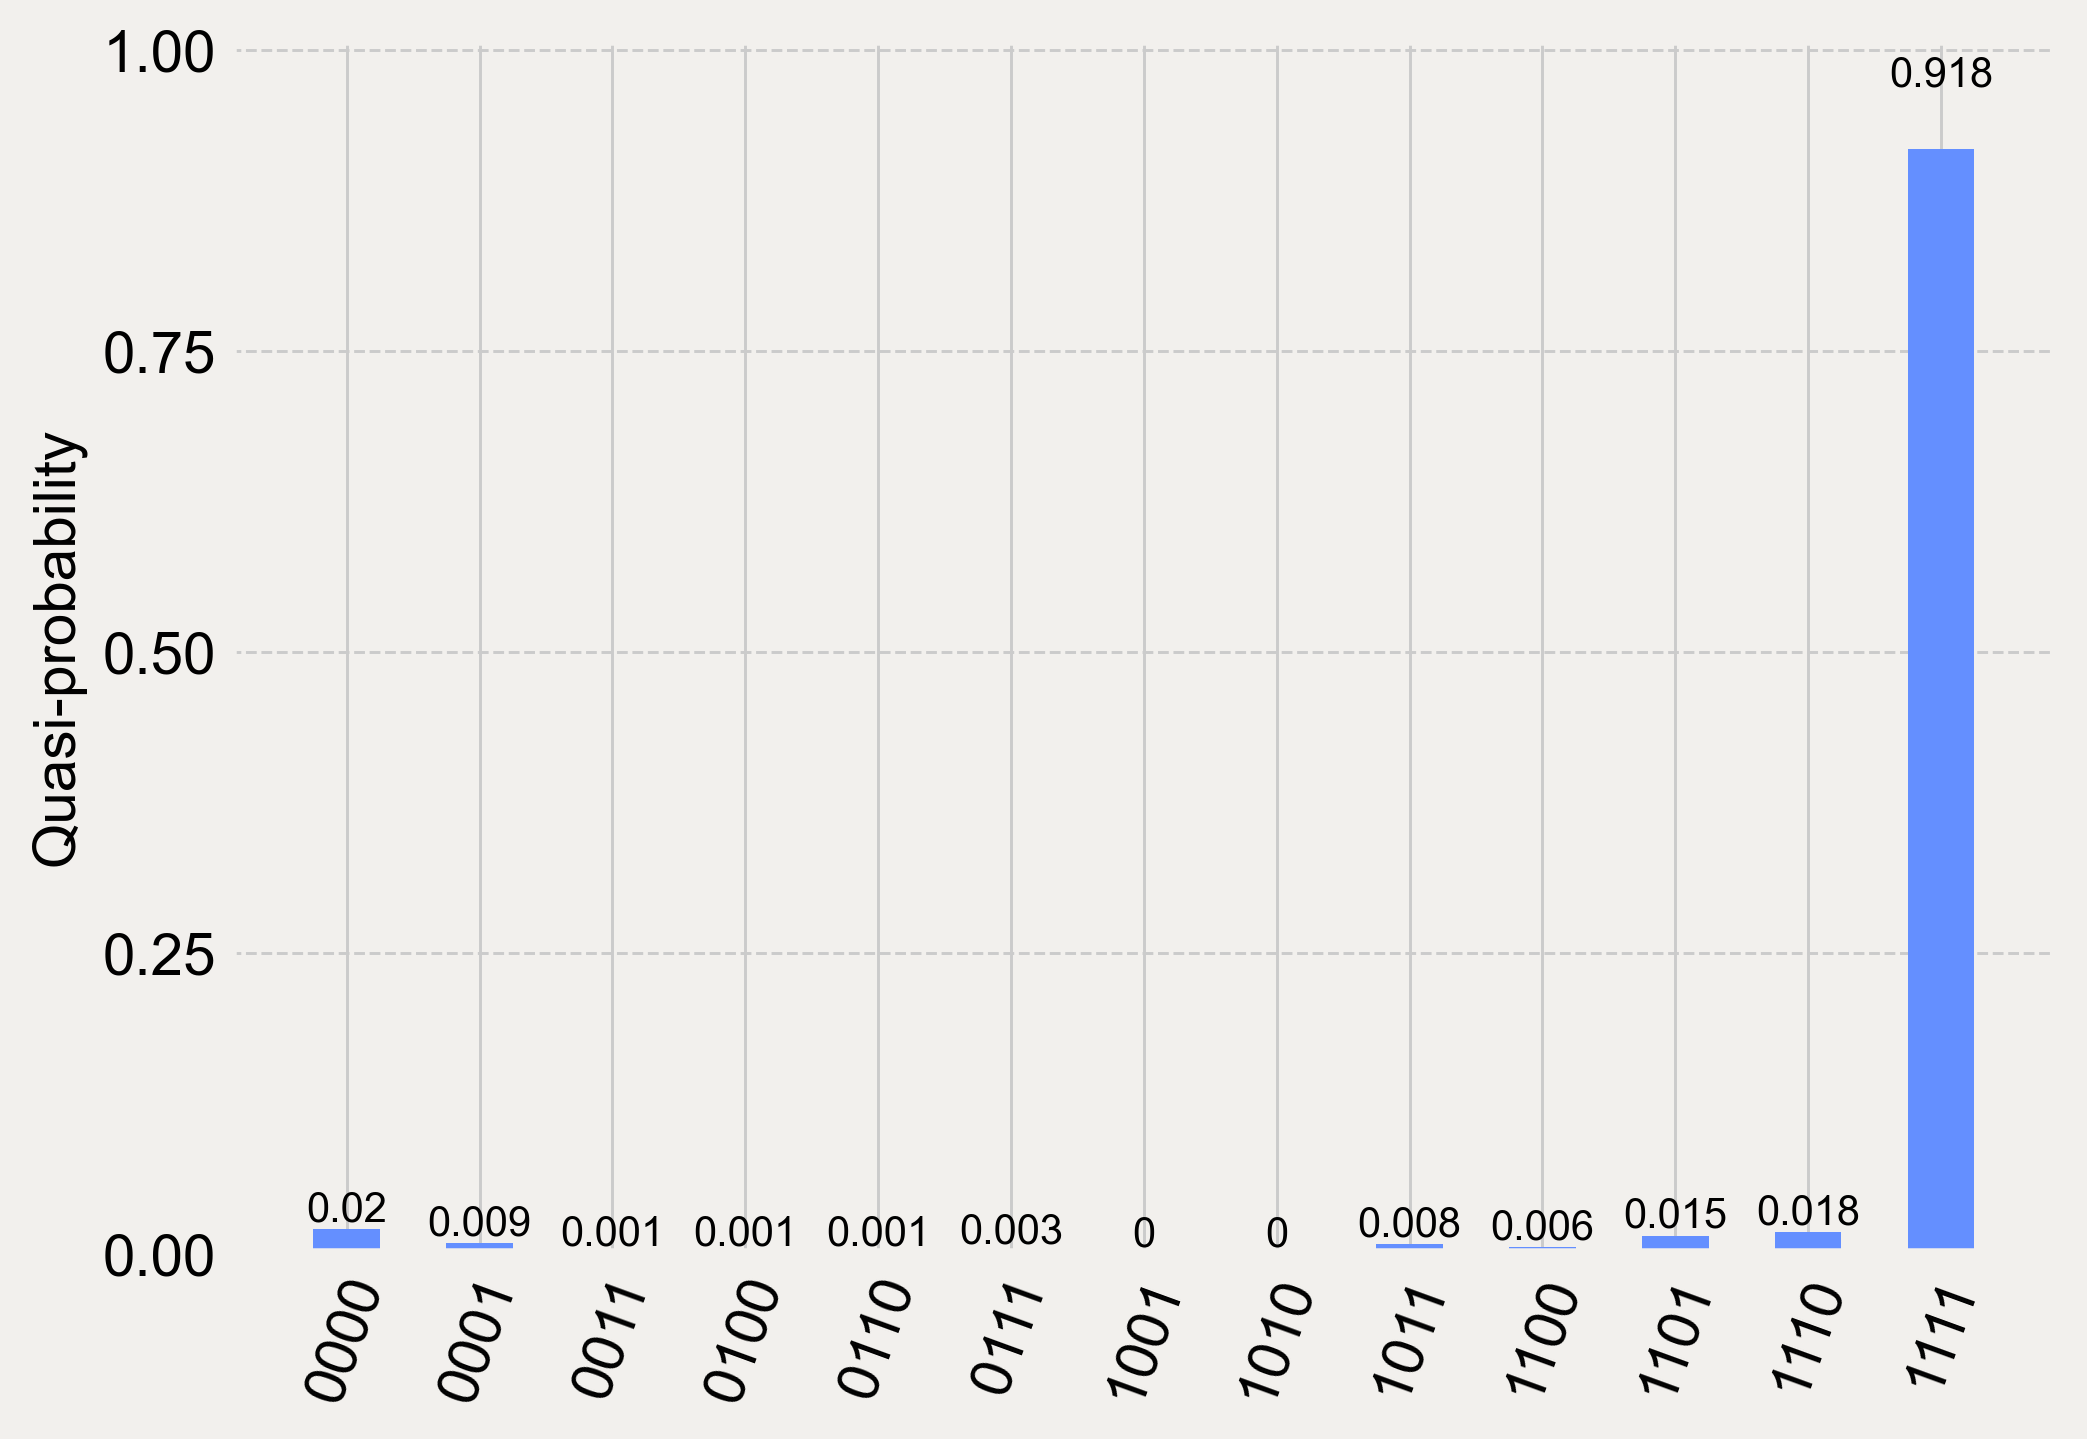

In [27]:
plot_distribution(res.quasi_dists[0].binary_probabilities())

Note that, if need be, we can use the job ID to get the job result at a later time from the service object:

In [28]:
service.job(job.job_id())

<RuntimeJob('cirvhsh1s2cfkgtu1gr0', 'sampler')>

### Metadata

Having run on an actual device, we can now take a look at metadata again:

In [29]:
res.metadata

[{'shots': 4000,
  'readout_mitigation_overhead': 1.1282893087087658,
  'readout_mitigation_time': 0.04767805524170399}]

Here, `metadata` now has three items.  The first, is the number of "shots", or number of times the circuit was executed and sampled.  The number given here is the default.  The other two characterize the readout error mitigation process.

### Things to be careful of

With the generalization to quasi-probability distributions some things that work for canonical probability distributions do not work when negative values are encountered.  One such example is computing the fidelity between two distributions.  For example, if the quasi-probability distribution has negative values then the fidelity calculation will fail due to the use of sqrts.

In [56]:
hellinger_fidelity(res.quasi_dists[0], res.quasi_dists[0])

/Users/paul/mambaforge/envs/qiskit/lib/python3.11/site-packages/qiskit/quantum_info/analysis/distance.py:45: RuntimeWarning: invalid value encountered in sqrt
  total += (np.sqrt(val) - np.sqrt(q_normed[key])) ** 2


nan

## Computing expectation values

Most sampling algorithms are not suitable for execution on near-term quantum computers.  Instead, algorithms designed to work on noisy quantum processors typically make use of expectation values computed from the sampled distributions.  Computing expectation values can be viewed as nothing more than sampling with additional classical processing.  However, having a specialized function to do so allows removal of a lot of boilerplate code, and lets one use error mitigation techniques that are designed for mitigating expectation values only.

We can compute expectation values via the `Estimator` primitive. The `Estimator` requires both a quantum circuit and an operator written as a linear combination of Pauli terms.  Unlike the `Sampler` above where our circuit must have measurements attached to it, circuits sent the `Estimator` **should not** have any measurements!  This is because the `Estimator` will automatically add post-rotation gates to your circuit that are needed for non-diagonal observables to get the measurement basis correct.

Let us begin by constructing a circuit of interest.  Here we choose the "controlled-Hadamard Ladder" circuit; a circuit with no practical value, but is useful for testing:

In [5]:
def cntrl_hadamard_ladder(N, measurements=False):
    """Create a controlled-Hadamard ladder circuit
    
    Parameters:
        N (int): number
        
    Returns:
        QuantumCircuit
    """
    qc = QuantumCircuit(N)

    qc.x(range(N))
    qc.h(range(N))

    for kk in range(N // 2, 0, -1):
        qc.ch(kk, kk - 1)
    for kk in range(N // 2, N - 1):
        qc.ch(kk, kk + 1)
    if measurements:
        qc.measure_all()
    return qc

We will create a 6-qubit version of this circuit with no measurements (as required for the `Estimator`)

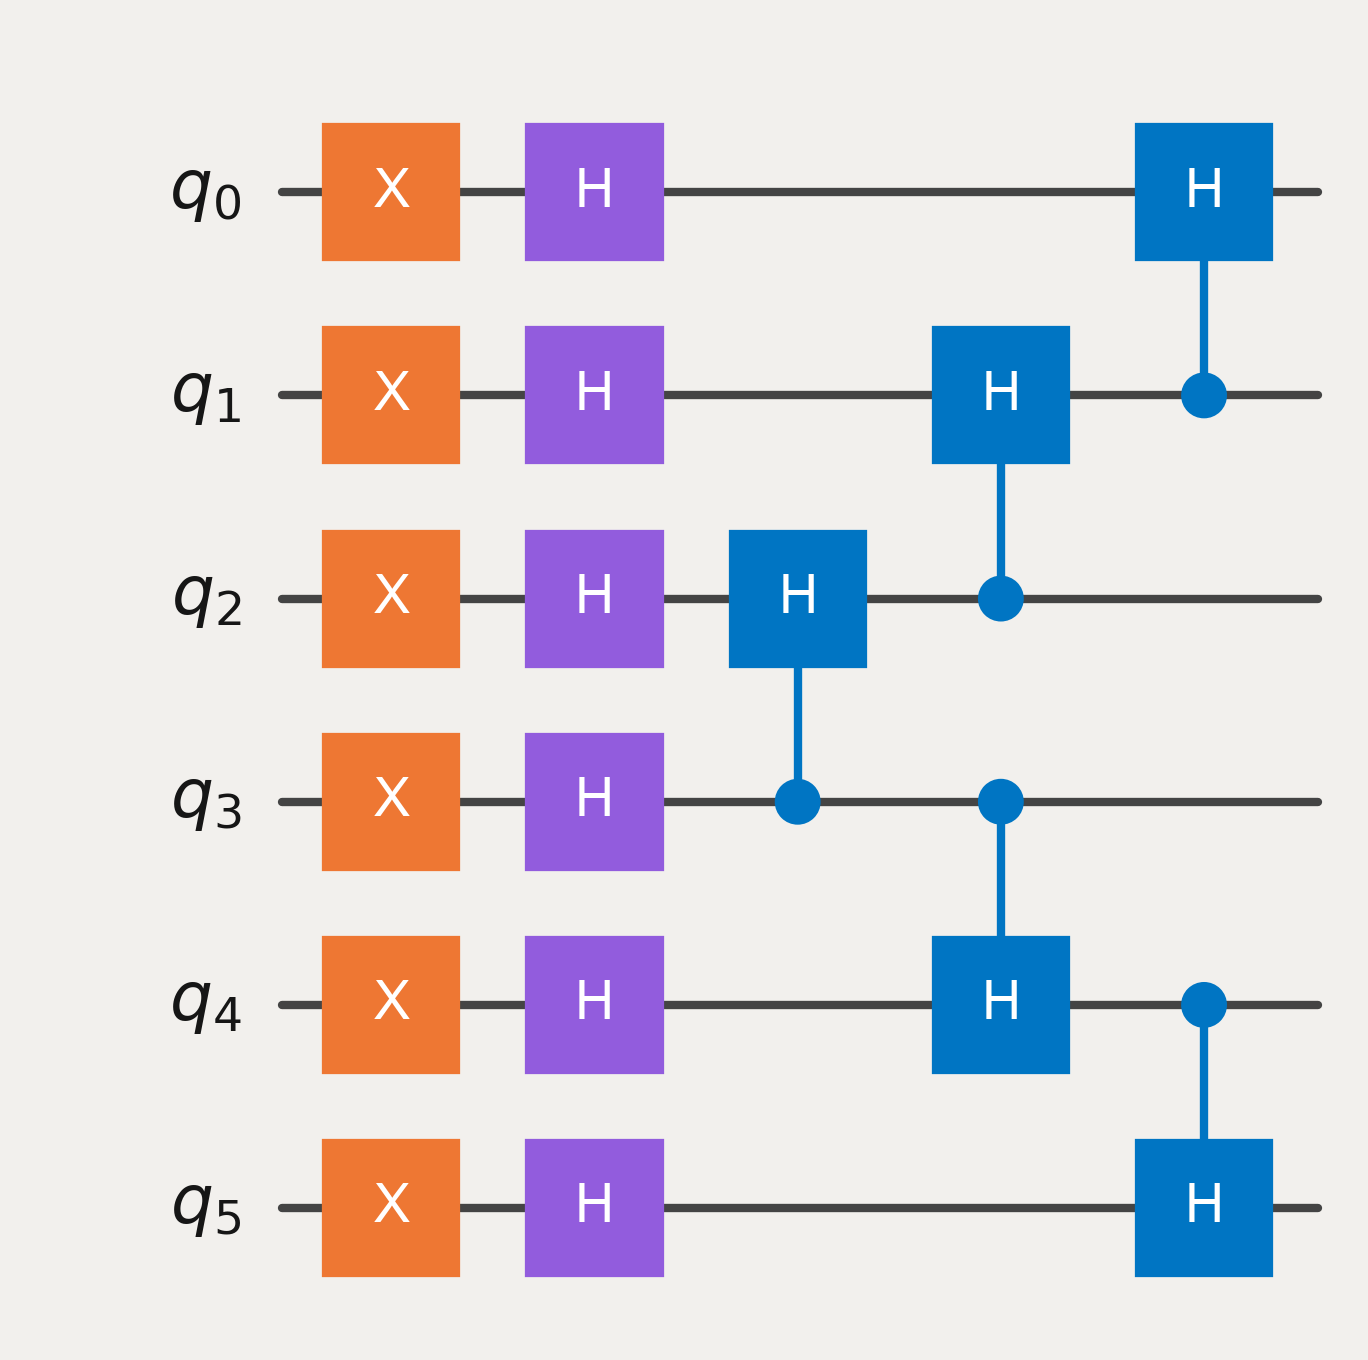

In [6]:
N = 6
qc2 = cntrl_hadamard_ladder(N, measurements=False) 
qc2.draw('mpl')

Again, for computing expectation values we need not only a circuit that generates a quantum state, but also a operator whose value we wish to measure in that state.  Let us select 3 possible expectation values here, using the `SparsePauliOp` class to represent them:

In [7]:
opers = [SparsePauliOp('Z'*N), 
         SparsePauliOp('I'*(N-2)+'ZZ'), 
         SparsePauliOp('I'*(N-1)+'Z')]
opers

[SparsePauliOp(['ZZZZZZ'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IIIIZZ'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IIIIIZ'],
               coeffs=[1.+0.j])]

Like before, since the problem size is small, we can directly compute the ideal answer using the primitives built into Qiskit:

In [8]:
qiskit_estimator = QiskitEstimator()

Because we have three operators of interest, we need to send the same circuit each time (send one circuit per operator)

In [9]:
ideal_res = qiskit_estimator.run([qc2]*3, opers).result()
ideal_res

EstimatorResult(values=array([ 0.4375,  0.875 , -0.875 ]), metadata=[{}, {}, {}])

The answers obtained are the ideal answers with no noise or finite sampling effects, and are returned as floating-point values in a NumPy array as the `values` attribute of the `EstimatorResult` object:

In [65]:
ideal_res.values

array([ 0.4375,  0.875 , -0.875 ])

Making a call to real hardware is similar to what we did for the `Sampler`

In [11]:
estimator = Estimator(backend)

In [12]:
est_res = estimator.run([qc2]*3, opers).result()
est_res

EstimatorResult(values=array([ 0.35695219,  0.86797002, -0.85561605]), metadata=[{'variance': 4.307453001240013, 'shots': 4000, 'readout_mitigation_num_twirled_circuits': 16, 'readout_mitigation_shots_calibration': 8192}, {'variance': 2.154490689743005, 'shots': 4000, 'readout_mitigation_num_twirled_circuits': 16, 'readout_mitigation_shots_calibration': 8192}, {'variance': 1.8643044529982833, 'shots': 4000, 'readout_mitigation_num_twirled_circuits': 16, 'readout_mitigation_shots_calibration': 8192}])

In [13]:
est_res.values

array([ 0.35695219,  0.86797002, -0.85561605])

In [14]:
est_res.metadata

[{'variance': 4.307453001240013,
  'shots': 4000,
  'readout_mitigation_num_twirled_circuits': 16,
  'readout_mitigation_shots_calibration': 8192},
 {'variance': 2.154490689743005,
  'shots': 4000,
  'readout_mitigation_num_twirled_circuits': 16,
  'readout_mitigation_shots_calibration': 8192},
 {'variance': 1.8643044529982833,
  'shots': 4000,
  'readout_mitigation_num_twirled_circuits': 16,
  'readout_mitigation_shots_calibration': 8192}]

New in the metadata is the `variance` field that takes into account the fact that our estimate of the expectation value has some uncertainty with it.  This combined with the number of shots is useful in error analysis.

Additionally, the `readout_mitigation_*` items relate to readout error mitigation, but differ from those in the `Sampler` as it uses a different method.

## Simulators in Runtime

The simulation capabilities are also available in the Qiskit Runtime.  Namely I can ask the service to show us the simulators using the `simulator` keyword argument to filter:

In [8]:
service.backends(simulator=True)

[<IBMBackend('simulator_stabilizer')>,
 <IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('ibmq_qasm_simulator_de')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('simulator_statevector')>,
 <IBMBackend('ibmq_qasm_simulator')>]

The most useful for us will be the `ibmq_qasm_simulator` that will sample the distribution generated by a circuit, possibly under noisy evolution, a finite number of times

In [15]:
sim = service.get_backend('ibmq_qasm_simulator')

## Setting options

There are many options available to users of Runtime.  Chief among these is the number of shots, but there are several other important options that control how circuits are pre-processed, executed, and post-processed.  We will show how to set some of these options now

In [29]:
qiskit_estimator.run(qc2, opers[0], shots=12345).result()

EstimatorResult(values=array([0.4462073]), metadata=[{'variance': 0.8085937499999999, 'shots': 12345}])

In [16]:
sim_estimator = Estimator(sim)
sim_estimator.run(qc2, opers[0], shots=54321).result()

EstimatorResult(values=array([0.44139467]), metadata=[{'variance': 0.8051707431678025, 'shots': 54321}])

### Qiskit Runtime `Options` class

The Qiskit runtime also supports setting options via an `Options` class.  We can see the default options by creating an empty `Options` class:

In [16]:
options = Options()
options

Options(optimization_level=None, resilience_level=None, max_execution_time=None, transpilation=TranspilationOptions(skip_transpilation=False, initial_layout=None, layout_method=None, routing_method=None, approximation_degree=None), resilience=ResilienceOptions(noise_amplifier='TwoQubitAmplifier', noise_factors=(1, 3, 5), extrapolator='LinearExtrapolator'), execution=ExecutionOptions(shots=4000, init_qubits=True), environment=EnvironmentOptions(log_level='WARNING', callback=None, job_tags=[]), simulator=SimulatorOptions(noise_model=None, seed_simulator=None, coupling_map=None, basis_gates=None))

There are top-level / commonly used settings such as `optimization_level`, `resilience_level`, and `max_execution_time`, and a collection of sub-options, sorted by what they do:

In [17]:
options.execution

ExecutionOptions(shots=4000, init_qubits=True)

In [18]:
options.simulator

SimulatorOptions(noise_model=None, seed_simulator=None, coupling_map=None, basis_gates=None)

In [19]:
options.transpilation

TranspilationOptions(skip_transpilation=False, initial_layout=None, layout_method=None, routing_method=None, approximation_degree=None)

In [20]:
options.resilience

ResilienceOptions(noise_amplifier='TwoQubitAmplifier', noise_factors=(1, 3, 5), extrapolator='LinearExtrapolator')

In [18]:
options.execution.shots = 12345
options

Options(optimization_level=None, resilience_level=None, max_execution_time=None, transpilation=TranspilationOptions(skip_transpilation=False, initial_layout=None, layout_method=None, routing_method=None, approximation_degree=None), resilience=ResilienceOptions(noise_amplifier='TwoQubitAmplifier', noise_factors=(1, 3, 5), extrapolator='LinearExtrapolator'), execution=ExecutionOptions(shots=12345, init_qubits=True), environment=EnvironmentOptions(log_level='WARNING', callback=None, job_tags=[]), simulator=SimulatorOptions(noise_model=None, seed_simulator=None, coupling_map=None, basis_gates=None))

In [24]:
Options(execution={'shots':54321})

Options(optimization_level=None, resilience_level=None, max_execution_time=None, transpilation=TranspilationOptions(skip_transpilation=False, initial_layout=None, layout_method=None, routing_method=None, approximation_degree=None), resilience=ResilienceOptions(noise_amplifier='TwoQubitAmplifier', noise_factors=(1, 3, 5), extrapolator='LinearExtrapolator'), execution=ExecutionOptions(shots=54321, init_qubits=True), environment=EnvironmentOptions(log_level='WARNING', callback=None, job_tags=[]), simulator=SimulatorOptions(noise_model=None, seed_simulator=None, coupling_map=None, basis_gates=None))

In order to use the `Option` class, you must pass it when initializing a primitive:

In [19]:
sim_estimator = Estimator(sim, options=options)

In [20]:
sim_estimator.run(qc2, opers[0]).result()

EstimatorResult(values=array([0.44673957]), metadata=[{'variance': 0.8004237559918772, 'shots': 12345}])

But I can still overload the value in `run()` if I want:

In [28]:
sim_estimator.run(qc2, opers[0], shots=10).result()

EstimatorResult(values=array([0.8]), metadata=[{'variance': 0.3599999999999999, 'shots': 10}])

## Runtime Sessions

Part of the Qiskit Runtime is the ability to combine multiple calls to primitives together in what are called  **Sessions**.  The notion of session closely follows that of a [networking session](https://en.wikipedia.org/wiki/Session_(computer_science)).  Once a session is opened, users can submit multiple primitive jobs to a session, of either type of primitive, and .  Each of these jobs gets executed sequentially until either there are no more jobs to process or the session time limit is reached.

In general, there are two ways in which sessions can be utilized.  First, an user can execute a collection of one or more jobs that are independent.  Second, one can have two or more jobs that are interconnected, with later jobs conditioned on the results from those previously executed.  This latter case is typical for iterative algorithms such as variational methods.

![independent](images/runtime2/independent.png)

![related](images/runtime2/related.png)

### Sessions for independent jobs

There are two ways to ways to make use of sessions.  First, we can directly make a session instance using the backend instance that we want to run on:

In [29]:
session = Session(backend=backend)

when we create either a `Sampler` or an `Estimator`, if we pass the `session` to it, it tells the primitives that the jobs should be logically connected, and executed as a group on the quantum processor

In [30]:
sampler = Sampler(session=session)
estimator = Estimator(session=session)

We can now use these primitives to launch multiple jobs that will execute one after another on the QPU.  For example, lets run our previous two circuits back-to-back

In [31]:
samp_job = sampler.run(qc)
est_job = estimator.run(qc2, opers[0])

That's it.  We can continue to add jobs to the session at any point, provided that the total runtime of the session is not longer than the default 8hr time limit.  Once all the results are returned, we can **optionally** close the session:

In [33]:
samp_res = samp_job.result()
est_res = est_job.result()
session.close()

<div class="alert alert-danger">
   <div>
       <big><b>Danger</b></big>
   </div>
   <br>
    If you close a session with unfinished jobs in it, then those jobs will be canceled!
</div>

Because calling `session.close()` is messy at present, we suggest just letting the session go idle after 5 min of inactivity.

There is another way to use sessions, and that is via Python contexts (`with` statements).  The syntax is a bit opaque, so lets go through it:

In [34]:
with Session(backend=backend):
    # We need to pass nothing to the primitives because they "know"
    # about the context block
    sampler = Sampler()
    estimator = Estimator()
    samp_job = sampler.run(qc)
    est_job = estimator.run(qc2, opers[0])

At the end of the context block, the session is not closed, and one does not have access to it anymore.

<div class="alert alert-success">
   <div>
       <big><b>Upcoming feature</b></big>
   </div>
   <br>
    There will be an "I'm done" feature for sessions that will make life much easier starting around August!
</div>

## The headaches of hardware

By using the Runtime we have up until now avoided any discussion of how our circuits are being executed on hardware, nor have we discussed how the properties of hardware effect the outcomes of circuit execution, in particular how things like device noise cause deviations from ideal behavior.  

To get a feel for this, let us run our all-ones BV circuits, varying the circuit width from 2->19 qubits.

In [35]:
widths = range(2, 20)
circs = [bv_ones_circs(N) for N in widths]

Since BV is a sampling problem, we will use the sampler primitive. We could use a session but, when possible, it is best to batch as many jobs as possible into a single job.  As such, we will send a single sampler job containing all of our circuits:

In [38]:
sampler = Sampler(backend)

In [39]:
bv_job = sampler.run(circs, shots=int(1e4))

Since the target bit-string is always `'1'*(N-1)`, we can extract that probability, being careful to check if the value is there or not using `get()`.

In [40]:
dists = bv_job.result().quasi_dists

In [41]:
target_probs = [dists[idx].binary_probabilities().get('1'*(N-1), 0) for idx, N in enumerate(widths)]

Here I will do a fit, so that we can better see what is going on:

In [42]:
# Fitting function
def sigmoid(x, L ,x0, k, b):
    y = L / (1.0 + np.exp(-k*(x-x0))) + b
    return y

# Initial guess of parameters
p0 = [max(target_probs),
      np.median(widths),
      1,
      min(target_probs)]

# Do the fitting
popt, pcov = curve_fit(sigmoid, widths, target_probs, p0)

Plot the data and fit:

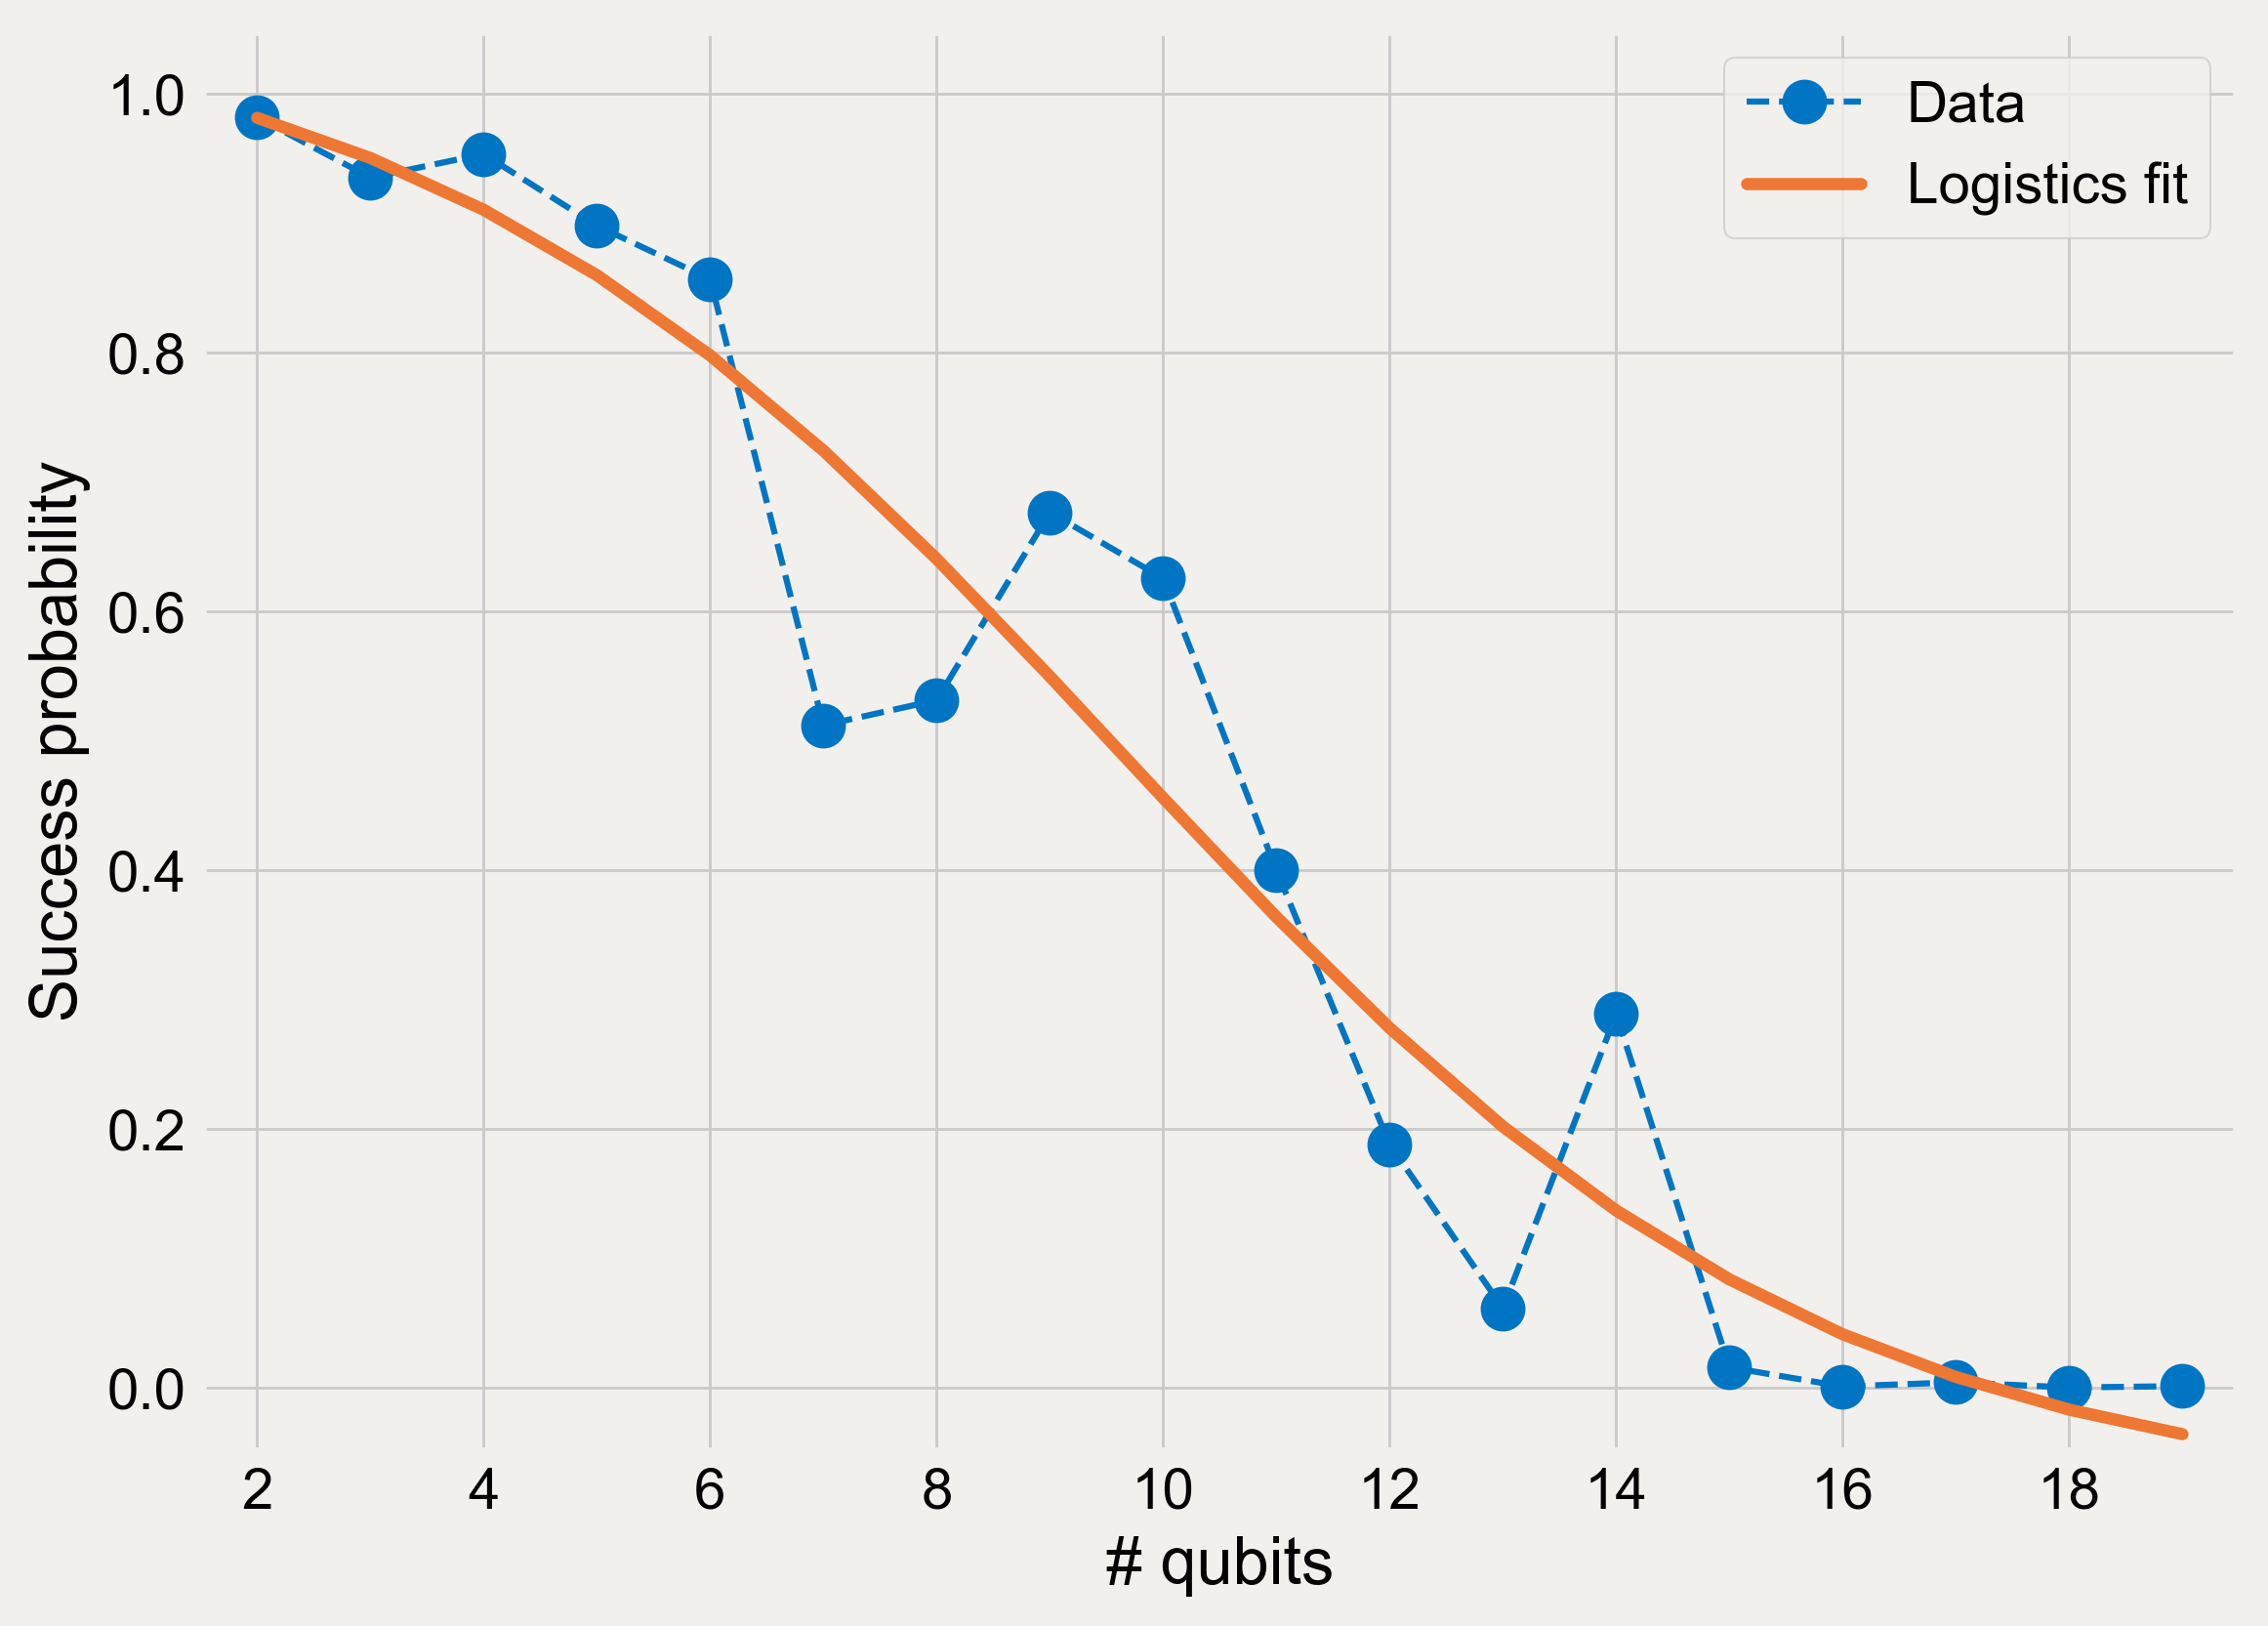

In [43]:
fig, ax = plt.subplots()
ax.plot(widths, target_probs, '--o', lw=1.5, label='Data')
ax.plot(widths, sigmoid(widths, *popt), '-', lw=3, label='Logistics fit')
ax.set_xlim([1.5,19.5])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('# qubits')
ax.set_ylabel('Success probability')
ax.legend();

There is a lot of information in this plot.  First the general trend is that, as the number of qubits grows in the circuit, the overall success probability goes down.  This is not too surprising given that each operation has some error, and the more qubits there are, the more operations need to be performed.

However, this decrease in success is not uniform.  Up until ~5 qubits the decrease is approximately linear, after which there is a sharp drop in the success rate until finally there is no signal at all.  As we will see, the shape of this curve is dictated by the limited qubit-qubit connectivity of IBM Quantum hardware.